This notebook documents part 3 of the **complementarity of image and demographic information**: combine the image latent spaces and demographics to predict mode choice and trip generation.

In [4]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2

from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"font.size":12})

import pandas as pd
import pickle as pkl
import numpy as np
from time import time

import glob
import itertools

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from M1_util_train_test import load_model, test
import mnl
import linear_reg
from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo, train_test_split
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
    plt.style.use('ggplot') # set the style; or "ggplot", "dark_background", "classic";

In [5]:
model_type = 'AE'
load_model_name = 'Autoencoder_raw'
load_model_file = 'ae'
model_code = 'BM1_A2'
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '220211'

variable_names = ['active','auto','mas','pt', 'trpgen']


# Load Model Embeddings

In [6]:
with open(proj_dir+"latent_space/"+model_type+"_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [7]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

# Load Demographics

In [8]:
# demographic variables

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']

demo_cs, demo_np = load_demo(data_dir)
demo = np.hstack((np.array(demo_cs).reshape(-1,1), demo_np))
demo = pd.DataFrame(demo, columns = ['geoid'] + demo_variables)
demo_split = train_test_split(demo, data_version='1571')

demo_train = demo_split[~demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)
demo_test = demo_split[demo_split['train_test'].astype(bool)][demo_variables].to_numpy(dtype=float)


# Load Trip Behavior

In [9]:
file = "origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, str(len(unique_ct)))

train_test_index = df_pivot['train_test'].astype(bool).to_numpy()

y = df_pivot[variable_names].to_numpy()
y_train = y[~train_test_index,:4]
y_test = y[train_test_index,:4]

In [10]:
embedding_train = aggregate_embeddings[~train_test_index, :]
embedding_test = aggregate_embeddings[train_test_index, :]

In [11]:
x_train = np.concatenate([demo_train, embedding_train], axis=1)
x_test = np.concatenate([demo_test, embedding_test], axis=1)

In [12]:
dim_demo = demo_train.shape[1]
dim_embed = embedding_train.shape[1]

In [13]:
auto_train = y[~train_test_index,1]
auto_test = y[train_test_index,1]

pt_train = y[~train_test_index,3]
pt_test = y[train_test_index,3]

active_train = y[~train_test_index,0]
active_test = y[train_test_index,0]

trpgen_train = y[~train_test_index,-1]
trpgen_test = y[train_test_index,-1]


# 1. Linear Regression

Highlights:

Auto Lasso 
- Parameter: 3.00e-06 Train R2: 0.6539 	 Test R: 0.6897 	 Nonzero coef: 10, 95

Auto Ridge
- Parameter: 2.00e-03 Train R2: 0.6745 	 Test R: 0.6786

PT Lasso
- Parameter: 5.00e-06 Train R2: 0.4972 	 Test R: 0.4311 	 Nonzero coef: 10, 21

PT Ridge
- Parameter: 5.00e-03 Train R2: 0.5589 	 Test R: 0.4386

Active Lasso
- Parameter: 5.00e-06 Train R2: 0.5261 	 Test R: 0.5748 	 Nonzero coef: 10, 44

Active Ridge
- Parameter: 5.00e-03 Train R2: 0.5618 	 Test R: 0.5702


Lasso for trip generation indicates that the images are useless when predicting trip generation rates.

## 1.1 Auto

In [32]:
# Lasso
train_r2 = []
test_r2 = []
demo_nonzero = []
embed_nonzero = []

regs = (1e-6)*np.array([0,0.1,1,3,5,7,9,10,20,50,100,1000 ])
for a in regs:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, auto_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d, %d" % 
          (a, lasso.score(x_train, auto_train), 
          lasso.score(x_test, auto_test), 
          np.sum(lasso.coef_[:dim_demo] != 0), 
          np.sum(lasso.coef_[dim_demo:] != 0)))
    train_r2.append(lasso.score(x_train, auto_train))
    test_r2.append(lasso.score(x_test, auto_test))
    demo_nonzero.append(np.sum(lasso.coef_[:dim_demo] != 0))
    embed_nonzero.append(np.sum(lasso.coef_[dim_demo:] != 0))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))



/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.504e-02, tolerance: 7.704e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge

Parameter: 0.00e+00 Train R2: 0.9986 	 Test R: -0.7146 	 Nonzero coef: 10, 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.073e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-07 Train R2: 0.9475 	 Test R: 0.3303 	 Nonzero coef: 10, 1131


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e+00, tolerance: 7.704e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-06 Train R2: 0.7191 	 Test R: 0.6683 	 Nonzero coef: 10, 278
Parameter: 3.00e-06 Train R2: 0.6539 	 Test R: 0.6897 	 Nonzero coef: 10, 95
Parameter: 5.00e-06 Train R2: 0.6303 	 Test R: 0.6809 	 Nonzero coef: 10, 55
Parameter: 7.00e-06 Train R2: 0.6182 	 Test R: 0.6740 	 Nonzero coef: 10, 39
Parameter: 9.00e-06 Train R2: 0.6105 	 Test R: 0.6663 	 Nonzero coef: 10, 25
Parameter: 1.00e-05 Train R2: 0.6076 	 Test R: 0.6645 	 Nonzero coef: 10, 23
Parameter: 2.00e-05 Train R2: 0.5828 	 Test R: 0.6382 	 Nonzero coef: 10, 14
Parameter: 5.00e-05 Train R2: 0.5163 	 Test R: 0.5578 	 Nonzero coef: 10, 5
Parameter: 1.00e-04 Train R2: 0.4742 	 Test R: 0.5194 	 Nonzero coef: 10, 2
Parameter: 1.00e-03 Train R2: 0.4315 	 Test R: 0.4918 	 Nonzero coef: 7, 0


In [77]:
labels

['100%', '55%', '14%', '5%', '3%', '2%', '1%', '1%', '1%', '0%', '0%', '0%']

In [79]:
for c in ax2.containers:
    print(c)

<BarContainer object of 12 artists>
<BarContainer object of 12 artists>


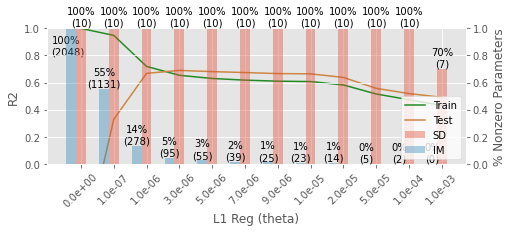

In [118]:
fig, ax = plt.subplots(1,1,figsize=(7.5,2.5))
ax2 = ax.twinx()
ax2.bar(np.arange(len(regs)), np.array(demo_nonzero)/10, width=0.3, alpha=0.4, label='SD')
ax2.bar(np.arange(len(regs))-.3, np.array(embed_nonzero)/2048, width=0.3, alpha=0.4, label='IM')
labels1 = []
labels2 = []
for a, b in zip(np.array(demo_nonzero)/10, np.array(embed_nonzero)/2048):
    labels1+=["{:.0%}\n({:})".format(a, int(10*a))] 
    if b == 1:
        labels2+=[""]
    else:
        labels2+=["{:.0%}\n({:})".format(b, int(2048*b))] 

for c,l in zip(ax2.containers, [labels1, labels2]):
    ax2.bar_label(c, labels=l)

ax.plot(np.arange(len(regs)), train_r2, linewidth=1.5, label="Train",c="forestgreen")
ax.plot(np.arange(len(regs)), test_r2, linewidth=1.5, label="Test",c="peru")
ax.annotate("100%\n(2048)", (-0.9,0.8))

ln1,lb1 = ax.get_legend_handles_labels()
ln2,lb2 = ax2.get_legend_handles_labels()

ax.set_xticks(np.arange(len(regs)))
ax.set_ylabel("R2") 
ax.set_xlabel("L1 Reg (theta)")
ax2.set_ylabel("% Nonzero Parameters")
ax.set_xticklabels(["%.1e" % a for a in regs], rotation=45)
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1e'))

ax.set_ylim([0,1])
ax2.set_ylim([0,1])

ax2.legend(ln1+ln2, lb1+lb2, facecolor='white', framealpha=0.8, loc=4)

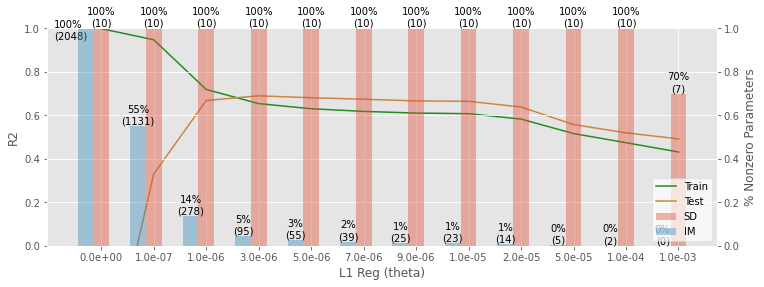

In [114]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax2 = ax.twinx()
ax2.bar(np.arange(len(regs)), np.array(demo_nonzero)/10, width=0.3, alpha=0.4, label='SD')
ax2.bar(np.arange(len(regs))-.3, np.array(embed_nonzero)/2048, width=0.3, alpha=0.4, label='IM')
labels1 = []
labels2 = []
for a, b in zip(np.array(demo_nonzero)/10, np.array(embed_nonzero)/2048):
    labels1+=["{:.0%}\n({:})".format(a, int(10*a))] 
    if b == 1:
        labels2+=[""]
    else:
        labels2+=["{:.0%}\n({:})".format(b, int(2048*b))] 

for c,l in zip(ax2.containers, [labels1, labels2]):
    ax2.bar_label(c, labels=l)

ax.plot(np.arange(len(regs)), train_r2, linewidth=1.5, label="Train",c="forestgreen")
ax.plot(np.arange(len(regs)), test_r2, linewidth=1.5, label="Test",c="peru")

ln1,lb1 = ax.get_legend_handles_labels()
ln2,lb2 = ax2.get_legend_handles_labels()

ax.annotate("100%\n(2048)", (-0.9,0.95))

ax.set_xticks(np.arange(len(regs)))
ax.set_ylabel("R2") 
ax.set_xlabel("L1 Reg (theta)")
ax2.set_ylabel("% Nonzero Parameters")
ax.set_xticklabels(["%.1e" % a for a in regs])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1e'))

ax.set_ylim([0,1])
ax2.set_ylim([0,1])


ax2.legend(ln1+ln2, lb1+lb2, facecolor='white', framealpha=0.7, loc=4)

In [15]:
# Ridge

for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, auto_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, auto_train), 
                                                              ridge.score(x_test, auto_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.46425e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -0.2852
Parameter: 1.00e-04 Train R2: 0.7985 	 Test R: 0.6389
Parameter: 1.00e-03 Train R2: 0.6957 	 Test R: 0.6754
Parameter: 2.00e-03 Train R2: 0.6745 	 Test R: 0.6786
Parameter: 3.00e-03 Train R2: 0.6631 	 Test R: 0.6784
Parameter: 4.00e-03 Train R2: 0.6553 	 Test R: 0.6773
Parameter: 5.00e-03 Train R2: 0.6493 	 Test R: 0.6757
Parameter: 6.00e-03 Train R2: 0.6444 	 Test R: 0.6739
Parameter: 7.00e-03 Train R2: 0.6402 	 Test R: 0.6720
Parameter: 8.00e-03 Train R2: 0.6366 	 Test R: 0.6701
Parameter: 1.00e-02 Train R2: 0.6303 	 Test R: 0.6662
Parameter: 2.00e-02 Train R2: 0.6087 	 Test R: 0.6484
Parameter: 5.00e-02 Train R2: 0.5729 	 Test R: 0.6126


## 1.2 PT 

In [17]:
# Lasso
for a in (1e-6)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, pt_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d, %d" % (a, lasso.score(x_train, pt_train), 
                                                                                  lasso.score(x_test, pt_test), 
                                                                                  np.sum(lasso.coef_[:dim_demo] != 0), 
                                                                                  np.sum(lasso.coef_[dim_demo:] != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))



/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-02, tolerance: 1.373e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

Parameter: 0.00e+00 Train R2: 0.9973 	 Test R: -1.6628 	 Nonzero coef: 10, 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+00, tolerance: 1.373e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-07 Train R2: 0.8658 	 Test R: 0.3066 	 Nonzero coef: 10, 794
Parameter: 1.00e-06 Train R2: 0.5801 	 Test R: 0.4218 	 Nonzero coef: 10, 144
Parameter: 2.00e-06 Train R2: 0.5416 	 Test R: 0.4293 	 Nonzero coef: 10, 79
Parameter: 3.00e-06 Train R2: 0.5212 	 Test R: 0.4296 	 Nonzero coef: 10, 47
Parameter: 4.00e-06 Train R2: 0.5073 	 Test R: 0.4301 	 Nonzero coef: 10, 31
Parameter: 5.00e-06 Train R2: 0.4972 	 Test R: 0.4311 	 Nonzero coef: 10, 21
Parameter: 6.00e-06 Train R2: 0.4917 	 Test R: 0.4272 	 Nonzero coef: 10, 16
Parameter: 7.00e-06 Train R2: 0.4855 	 Test R: 0.4225 	 Nonzero coef: 9, 15
Parameter: 8.00e-06 Train R2: 0.4784 	 Test R: 0.4173 	 Nonzero coef: 9, 15
Parameter: 1.00e-05 Train R2: 0.4660 	 Test R: 0.4050 	 Nonzero coef: 10, 10
Parameter: 2.00e-05 Train R2: 0.4243 	 Test R: 0.3454 	 Nonzero coef: 9, 3
Parameter: 5.00e-05 Train R2: 0.3931 	 Test R: 0.2974 	 Nonzero coef: 9, 1


In [18]:
# Ridge

for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, pt_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, pt_train), 
                                                              ridge.score(x_test, pt_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.46425e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -1.1901
Parameter: 1.00e-04 Train R2: 0.7438 	 Test R: 0.3946
Parameter: 1.00e-03 Train R2: 0.6149 	 Test R: 0.4305
Parameter: 2.00e-03 Train R2: 0.5889 	 Test R: 0.4360
Parameter: 3.00e-03 Train R2: 0.5751 	 Test R: 0.4380
Parameter: 4.00e-03 Train R2: 0.5659 	 Test R: 0.4386
Parameter: 5.00e-03 Train R2: 0.5589 	 Test R: 0.4386
Parameter: 6.00e-03 Train R2: 0.5533 	 Test R: 0.4383
Parameter: 7.00e-03 Train R2: 0.5486 	 Test R: 0.4376
Parameter: 8.00e-03 Train R2: 0.5446 	 Test R: 0.4369
Parameter: 1.00e-02 Train R2: 0.5378 	 Test R: 0.4350
Parameter: 2.00e-02 Train R2: 0.5164 	 Test R: 0.4241
Parameter: 5.00e-02 Train R2: 0.4856 	 Test R: 0.3972


## 1.3 Active

In [19]:
# Lasso
for a in (1e-6)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, active_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d, %d" % (a, lasso.score(x_train, active_train), 
                                                                                  lasso.score(x_test, active_test), 
                                                                                  np.sum(lasso.coef_[:dim_demo] != 0), 
                                                                                  np.sum(lasso.coef_[dim_demo:] != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))



/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e-02, tolerance: 3.791e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

Parameter: 0.00e+00 Train R2: 0.9978 	 Test R: -1.6454 	 Nonzero coef: 10, 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+00, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-07 Train R2: 0.9123 	 Test R: 0.1938 	 Nonzero coef: 10, 1009


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.405e-01, tolerance: 3.791e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-06 Train R2: 0.6277 	 Test R: 0.5448 	 Nonzero coef: 10, 215
Parameter: 2.00e-06 Train R2: 0.5794 	 Test R: 0.5637 	 Nonzero coef: 10, 115
Parameter: 3.00e-06 Train R2: 0.5552 	 Test R: 0.5699 	 Nonzero coef: 10, 82
Parameter: 4.00e-06 Train R2: 0.5388 	 Test R: 0.5711 	 Nonzero coef: 10, 59
Parameter: 5.00e-06 Train R2: 0.5261 	 Test R: 0.5748 	 Nonzero coef: 10, 44
Parameter: 6.00e-06 Train R2: 0.5161 	 Test R: 0.5743 	 Nonzero coef: 10, 36
Parameter: 7.00e-06 Train R2: 0.5072 	 Test R: 0.5701 	 Nonzero coef: 10, 31
Parameter: 8.00e-06 Train R2: 0.5012 	 Test R: 0.5669 	 Nonzero coef: 10, 24
Parameter: 1.00e-05 Train R2: 0.4928 	 Test R: 0.5620 	 Nonzero coef: 10, 19
Parameter: 2.00e-05 Train R2: 0.4532 	 Test R: 0.5345 	 Nonzero coef: 10, 9
Parameter: 5.00e-05 Train R2: 0.3933 	 Test R: 0.4841 	 Nonzero coef: 10, 3


In [20]:
# Ridge

for a in (1e-3)*np.array([0,0.1,1,2,3,4,5,6,7,8,10,20,50]):

    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(x_train, active_train)
#     with open(out_dir+sampling+"_"+model_code+"_regression_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%s,%s,%s,%.5f,%.4f,%.4f,%s,%s,%d,%d\n" % (model_run_date, model_type, variable_names[-1], a, 
#             ridge.score(x_train, trpgen_train), ridge.score(x_test, trpgen_test), 'ridge', zoomlevel,
#             np.sum(ridge.coef_ != 0), len(ridge.coef_)))
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f" % (a, ridge.score(x_train, active_train), 
                                                              ridge.score(x_test, active_test)))

/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.46425e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


Parameter: 0.00e+00 Train R2: 1.0000 	 Test R: -0.7980
Parameter: 1.00e-04 Train R2: 0.7466 	 Test R: 0.5212
Parameter: 1.00e-03 Train R2: 0.6210 	 Test R: 0.5589
Parameter: 2.00e-03 Train R2: 0.5945 	 Test R: 0.5657
Parameter: 3.00e-03 Train R2: 0.5798 	 Test R: 0.5685
Parameter: 4.00e-03 Train R2: 0.5696 	 Test R: 0.5697
Parameter: 5.00e-03 Train R2: 0.5618 	 Test R: 0.5702
Parameter: 6.00e-03 Train R2: 0.5554 	 Test R: 0.5701
Parameter: 7.00e-03 Train R2: 0.5500 	 Test R: 0.5698
Parameter: 8.00e-03 Train R2: 0.5453 	 Test R: 0.5693
Parameter: 1.00e-02 Train R2: 0.5375 	 Test R: 0.5678
Parameter: 2.00e-02 Train R2: 0.5119 	 Test R: 0.5583
Parameter: 5.00e-02 Train R2: 0.4742 	 Test R: 0.5356


## 1.4 Trip Generation

In [22]:
for a in (1e-3)*np.array([0,0.1,6,7,8,10,11,12,13,14,15,20,50]):
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x_train, trpgen_train)
    print("Parameter: %.2e Train R2: %.4f \t Test R: %.4f \t Nonzero coef: %d, %d" % (a, lasso.score(x_train, trpgen_train), 
                                                                                  lasso.score(x_test, trpgen_test), 
                                                                                  np.sum(lasso.coef_[:dim_demo] != 0), 
                                                                                  np.sum(lasso.coef_[dim_demo:] != 0)))

#     with open(out_dir+"BA_"+variable_names[-1]+".csv", "a") as f:
#         f.write("%.6f,%.4f,%.4f,%s,%d,%d\n" % (a, 
#             lasso.score(x_train, trpgen_train), lasso.score(x_test, trpgen_test), 'lasso', 
#             np.sum(lasso.coef_ != 0), len(lasso.coef_)))

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.779e+02, tolerance: 3.630e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

Parameter: 0.00e+00 Train R2: 0.9968 	 Test R: -2.9633 	 Nonzero coef: 10, 2048


/home/jtl/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.414e+03, tolerance: 3.630e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Parameter: 1.00e-04 Train R2: 0.4654 	 Test R: 0.0389 	 Nonzero coef: 10, 246
Parameter: 6.00e-03 Train R2: 0.2397 	 Test R: 0.1549 	 Nonzero coef: 9, 0
Parameter: 7.00e-03 Train R2: 0.2394 	 Test R: 0.1563 	 Nonzero coef: 9, 0
Parameter: 8.00e-03 Train R2: 0.2392 	 Test R: 0.1572 	 Nonzero coef: 8, 0
Parameter: 1.00e-02 Train R2: 0.2387 	 Test R: 0.1578 	 Nonzero coef: 7, 0
Parameter: 1.10e-02 Train R2: 0.2386 	 Test R: 0.1578 	 Nonzero coef: 7, 0
Parameter: 1.20e-02 Train R2: 0.2386 	 Test R: 0.1578 	 Nonzero coef: 7, 0
Parameter: 1.30e-02 Train R2: 0.2385 	 Test R: 0.1578 	 Nonzero coef: 7, 0
Parameter: 1.40e-02 Train R2: 0.2384 	 Test R: 0.1578 	 Nonzero coef: 7, 0
Parameter: 1.50e-02 Train R2: 0.2383 	 Test R: 0.1578 	 Nonzero coef: 7, 0
Parameter: 2.00e-02 Train R2: 0.2379 	 Test R: 0.1576 	 Nonzero coef: 7, 0
Parameter: 5.00e-02 Train R2: 0.2328 	 Test R: 0.1515 	 Nonzero coef: 6, 0


# 2. Linear Regression (PyTorch)

In [16]:
def pytorch_lr(w1_list, w2_list, lr1_list, lr2_list, x1, x2, y1, y2, dim_demo, reg_type='L2'):
    
    mseloss = nn.MSELoss(reduction='sum')
    
    trainset = SurveyDataset(torch.tensor(x1,  dtype=torch.float), torch.tensor(y1, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)

    testset = SurveyDataset(torch.tensor(x2, dtype=torch.float), torch.tensor(y2, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    # decay rates for embedding
#     w1_list = [0]
    # decay rates for demo (There is no demo in this case)
#     w2_list = [0]
    # lr_list = [0.005,0.01, 0.02]
#     lr_list = [0.002]

    dim_demo = dim_demo
    dim_embed = x1.shape[1] - dim_demo

    for lr1, lr2 in zip(lr1_list, lr2_list):

        for w1, w2 in itertools.product(w1_list, w2_list):

            # model setup
            model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo)

#             print(model)
            embed_params = []
            demo_params = []
            other_params = []
            for name, m in model.named_parameters():
        #             print(name)
                if 'embed' in name:
                    embed_params.append(m)
                elif 'demo' in name:
                    demo_params.append(m)
                else:
                    other_params.append(m)

#             optimizer = torch.optim.Adam([{'params':demo_params,'lr':lr}])
            
            if reg_type == 'L2':
                optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1,'lr':lr1},
                                          {'params':demo_params,'weight_decay':w2, 'lr':lr2}])
            else:
                optimizer = torch.optim.Adam([{'params':embed_params,'lr':lr1},
                                          {'params':demo_params,'lr':lr2}])
#             print(optimizer)
#             print(demo_params)
            
            # model training
            ref1 = 0
            ref2 = 0

            for epoch in range(10000):

                mse_ = 0

                for batch, (x_batch, y_batch) in enumerate(trainloader):
                    # Compute prediction and loss
                    pred = model(x_batch[:, dim_demo:], x_batch[:, :dim_demo])
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()
                    
                    if reg_type == 'L1':
                        l1_reg = torch.tensor(0.)
                        for p in embed_params:
                            l1_reg += w1 * torch.norm(p,1)
                        for p in demo_params:
                            l1_reg += w2 * torch.norm(p,1)
                        mse += l1_reg
                        
                    # Backpropagation
                    optimizer.zero_grad()
                    mse.backward()
                    optimizer.step()

                    model.embed.weight.data = (torch.abs(model.embed.weight)>1e-3) * model.embed.weight
                    model.demo.weight.data = (torch.abs(model.demo.weight)>1e-3) * model.demo.weight

                train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
                train_mse = mse_/len(trainset)

                if epoch % 20 == 0:
                    print(f"[epoch: {epoch:>3d}] Train MSE : {train_mse:.4f} R2 score: {train_r:.3f} ")
                loss_ = train_mse

#                 if epoch % 5 == 0:
#                     if epoch >=40:
#                         if (np.abs(loss_ - ref1)/ref1<0.0005) & (np.abs(loss_ - ref2)/ref2<0.0005):
#                             print("Early stopping at epoch", epoch)
#                             print(ref2, ref1, loss_)
#                             break
#                         if (ref1 < loss_) & (ref1 < ref2):
#                             print("Diverging. stop.")
#                             break
#                         if loss_ < best:
#                             best = loss_
#                             best_epoch = epoch
#                     else:
#                         best = loss_
#                         best_epoch = epoch

#                     ref2 = ref1
#                     ref1 = loss_

                if epoch % 20 == 0:

                    mse_ = 0 

                    for batch, (x_batch, y_batch) in enumerate(testloader):
                        pred = model(x_batch[:, dim_demo:], x_batch[:, :dim_demo])
                        pred = F.relu(pred).squeeze()

                        mse = mseloss(pred, y_batch)
                        mse_ += mse.item()
                        
#                     print(len(testset))

                    test_mse = mse_/len(testset)
                    test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                    print(f"[epoch: {epoch:>3d}] Test MSE {test_mse:.4f} R2 score: {test_r:.3f} ")
                    print(f"Nonzero parameters: {torch.sum(model.demo.weight>0):>4d} {torch.sum(model.embed.weight>0):>4d}")
    return model
                        
    #         with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
    #             f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
    #                 (model_run_date, model_type, zoomlevel, "LR", lr, w1, 
    #                   train_rmse, train_r, test_rmse, test_r))

In [17]:
model = pytorch_lr(w1_list=[5e-6], w2_list=[5e-6], lr1_list=[0.001], lr2_list=[0.001], 
                   x1=x_train, x2=x_test, y1=auto_train, y2=auto_test, dim_demo=dim_demo, reg_type='L1')


[epoch:   0] Train MSE : 0.6495 R2 score: -10.921 
[epoch:   0] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    2  933
[epoch:  20] Train MSE : 0.6495 R2 score: -10.921 
[epoch:  20] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    2    8
[epoch:  40] Train MSE : 0.6495 R2 score: -10.921 
[epoch:  40] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    2    0
[epoch:  60] Train MSE : 0.6495 R2 score: -10.921 
[epoch:  60] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    1    0
[epoch:  80] Train MSE : 0.6495 R2 score: -10.921 
[epoch:  80] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    1    0
[epoch: 100] Train MSE : 0.6495 R2 score: -10.921 
[epoch: 100] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    1    0
[epoch: 120] Train MSE : 0.6495 R2 score: -10.921 
[epoch: 120] Test MSE 0.6646 R2 score: -12.113 
Nonzero parameters:    1    0
[epoch: 140] Train MSE : 0.6495 R2 score: -10.921 
[epoch: 140] Test MSE 0.6646 R2 score: -12.113

[epoch: 1300] Train MSE : 0.0393 R2 score: 0.279 
[epoch: 1300] Test MSE 0.0363 R2 score: 0.284 
Nonzero parameters:    4 1330
[epoch: 1320] Train MSE : 0.0392 R2 score: 0.281 
[epoch: 1320] Test MSE 0.0361 R2 score: 0.287 
Nonzero parameters:    4 1320
[epoch: 1340] Train MSE : 0.0390 R2 score: 0.284 
[epoch: 1340] Test MSE 0.0360 R2 score: 0.289 
Nonzero parameters:    4 1300
[epoch: 1360] Train MSE : 0.0389 R2 score: 0.286 
[epoch: 1360] Test MSE 0.0359 R2 score: 0.292 
Nonzero parameters:    4 1289
[epoch: 1380] Train MSE : 0.0388 R2 score: 0.288 
[epoch: 1380] Test MSE 0.0358 R2 score: 0.294 
Nonzero parameters:    4 1278
[epoch: 1400] Train MSE : 0.0387 R2 score: 0.291 
[epoch: 1400] Test MSE 0.0356 R2 score: 0.297 
Nonzero parameters:    4 1257
[epoch: 1420] Train MSE : 0.0385 R2 score: 0.293 
[epoch: 1420] Test MSE 0.0355 R2 score: 0.299 
Nonzero parameters:    4 1249
[epoch: 1440] Train MSE : 0.0384 R2 score: 0.295 
[epoch: 1440] Test MSE 0.0354 R2 score: 0.302 
Nonzero parame

[epoch: 2600] Train MSE : 0.0331 R2 score: 0.393 
[epoch: 2600] Test MSE 0.0296 R2 score: 0.415 
Nonzero parameters:    4  783
[epoch: 2620] Train MSE : 0.0330 R2 score: 0.394 
[epoch: 2620] Test MSE 0.0296 R2 score: 0.417 
Nonzero parameters:    4  780
[epoch: 2640] Train MSE : 0.0329 R2 score: 0.395 
[epoch: 2640] Test MSE 0.0295 R2 score: 0.418 
Nonzero parameters:    4  778
[epoch: 2660] Train MSE : 0.0329 R2 score: 0.397 
[epoch: 2660] Test MSE 0.0294 R2 score: 0.420 
Nonzero parameters:    4  774
[epoch: 2680] Train MSE : 0.0328 R2 score: 0.398 
[epoch: 2680] Test MSE 0.0293 R2 score: 0.422 
Nonzero parameters:    4  770
[epoch: 2700] Train MSE : 0.0327 R2 score: 0.399 
[epoch: 2700] Test MSE 0.0292 R2 score: 0.423 
Nonzero parameters:    4  760
[epoch: 2720] Train MSE : 0.0327 R2 score: 0.401 
[epoch: 2720] Test MSE 0.0292 R2 score: 0.425 
Nonzero parameters:    4  756
[epoch: 2740] Train MSE : 0.0326 R2 score: 0.402 
[epoch: 2740] Test MSE 0.0291 R2 score: 0.426 
Nonzero parame

[epoch: 3900] Train MSE : 0.0290 R2 score: 0.468 
[epoch: 3900] Test MSE 0.0250 R2 score: 0.507 
Nonzero parameters:    4  588
[epoch: 3920] Train MSE : 0.0289 R2 score: 0.469 
[epoch: 3920] Test MSE 0.0249 R2 score: 0.508 
Nonzero parameters:    4  584
[epoch: 3940] Train MSE : 0.0289 R2 score: 0.470 
[epoch: 3940] Test MSE 0.0249 R2 score: 0.509 
Nonzero parameters:    4  583
[epoch: 3960] Train MSE : 0.0288 R2 score: 0.471 
[epoch: 3960] Test MSE 0.0248 R2 score: 0.510 
Nonzero parameters:    4  580
[epoch: 3980] Train MSE : 0.0288 R2 score: 0.472 
[epoch: 3980] Test MSE 0.0248 R2 score: 0.511 
Nonzero parameters:    4  577
[epoch: 4000] Train MSE : 0.0287 R2 score: 0.473 
[epoch: 4000] Test MSE 0.0247 R2 score: 0.513 
Nonzero parameters:    4  575
[epoch: 4020] Train MSE : 0.0287 R2 score: 0.474 
[epoch: 4020] Test MSE 0.0246 R2 score: 0.514 
Nonzero parameters:    4  573
[epoch: 4040] Train MSE : 0.0286 R2 score: 0.475 
[epoch: 4040] Test MSE 0.0246 R2 score: 0.515 
Nonzero parame

[epoch: 5200] Train MSE : 0.0261 R2 score: 0.522 
[epoch: 5200] Test MSE 0.0216 R2 score: 0.575 
Nonzero parameters:    4  462
[epoch: 5220] Train MSE : 0.0260 R2 score: 0.522 
[epoch: 5220] Test MSE 0.0215 R2 score: 0.576 
Nonzero parameters:    4  457
[epoch: 5240] Train MSE : 0.0260 R2 score: 0.523 
[epoch: 5240] Test MSE 0.0215 R2 score: 0.576 
Nonzero parameters:    4  457
[epoch: 5260] Train MSE : 0.0259 R2 score: 0.524 
[epoch: 5260] Test MSE 0.0214 R2 score: 0.577 
Nonzero parameters:    4  455
[epoch: 5280] Train MSE : 0.0259 R2 score: 0.524 
[epoch: 5280] Test MSE 0.0214 R2 score: 0.578 
Nonzero parameters:    4  453
[epoch: 5300] Train MSE : 0.0259 R2 score: 0.525 
[epoch: 5300] Test MSE 0.0213 R2 score: 0.579 
Nonzero parameters:    4  451
[epoch: 5320] Train MSE : 0.0258 R2 score: 0.526 
[epoch: 5320] Test MSE 0.0213 R2 score: 0.580 
Nonzero parameters:    4  448
[epoch: 5340] Train MSE : 0.0258 R2 score: 0.526 
[epoch: 5340] Test MSE 0.0213 R2 score: 0.581 
Nonzero parame

[epoch: 6500] Train MSE : 0.0241 R2 score: 0.557 
[epoch: 6500] Test MSE 0.0192 R2 score: 0.622 
Nonzero parameters:    4  373
[epoch: 6520] Train MSE : 0.0241 R2 score: 0.558 
[epoch: 6520] Test MSE 0.0191 R2 score: 0.622 
Nonzero parameters:    4  368
[epoch: 6540] Train MSE : 0.0241 R2 score: 0.558 
[epoch: 6540] Test MSE 0.0191 R2 score: 0.623 
Nonzero parameters:    4  368
[epoch: 6560] Train MSE : 0.0240 R2 score: 0.559 
[epoch: 6560] Test MSE 0.0191 R2 score: 0.623 
Nonzero parameters:    4  366
[epoch: 6580] Train MSE : 0.0240 R2 score: 0.559 
[epoch: 6580] Test MSE 0.0191 R2 score: 0.624 
Nonzero parameters:    4  363
[epoch: 6600] Train MSE : 0.0240 R2 score: 0.559 
[epoch: 6600] Test MSE 0.0190 R2 score: 0.625 
Nonzero parameters:    4  363
[epoch: 6620] Train MSE : 0.0240 R2 score: 0.560 
[epoch: 6620] Test MSE 0.0190 R2 score: 0.625 
Nonzero parameters:    4  362
[epoch: 6640] Train MSE : 0.0240 R2 score: 0.560 
[epoch: 6640] Test MSE 0.0190 R2 score: 0.626 
Nonzero parame

[epoch: 7800] Train MSE : 0.0229 R2 score: 0.579 
[epoch: 7800] Test MSE 0.0178 R2 score: 0.650 
Nonzero parameters:    4  309
[epoch: 7820] Train MSE : 0.0229 R2 score: 0.579 
[epoch: 7820] Test MSE 0.0177 R2 score: 0.650 
Nonzero parameters:    4  309
[epoch: 7840] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 7840] Test MSE 0.0177 R2 score: 0.650 
Nonzero parameters:    4  309
[epoch: 7860] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 7860] Test MSE 0.0177 R2 score: 0.651 
Nonzero parameters:    4  307
[epoch: 7880] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 7880] Test MSE 0.0177 R2 score: 0.651 
Nonzero parameters:    4  307
[epoch: 7900] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 7900] Test MSE 0.0177 R2 score: 0.651 
Nonzero parameters:    4  306
[epoch: 7920] Train MSE : 0.0228 R2 score: 0.581 
[epoch: 7920] Test MSE 0.0177 R2 score: 0.652 
Nonzero parameters:    4  306
[epoch: 7940] Train MSE : 0.0228 R2 score: 0.581 
[epoch: 7940] Test MSE 0.0176 R2 score: 0.652 
Nonzero parame

[epoch: 9100] Train MSE : 0.0222 R2 score: 0.593 
[epoch: 9100] Test MSE 0.0170 R2 score: 0.665 
Nonzero parameters:    4  267
[epoch: 9120] Train MSE : 0.0222 R2 score: 0.593 
[epoch: 9120] Test MSE 0.0170 R2 score: 0.665 
Nonzero parameters:    4  267
[epoch: 9140] Train MSE : 0.0222 R2 score: 0.593 
[epoch: 9140] Test MSE 0.0170 R2 score: 0.665 
Nonzero parameters:    4  266
[epoch: 9160] Train MSE : 0.0222 R2 score: 0.593 
[epoch: 9160] Test MSE 0.0170 R2 score: 0.665 
Nonzero parameters:    4  264
[epoch: 9180] Train MSE : 0.0222 R2 score: 0.593 
[epoch: 9180] Test MSE 0.0170 R2 score: 0.665 
Nonzero parameters:    4  263
[epoch: 9200] Train MSE : 0.0222 R2 score: 0.593 
[epoch: 9200] Test MSE 0.0170 R2 score: 0.665 
Nonzero parameters:    4  260
[epoch: 9220] Train MSE : 0.0221 R2 score: 0.594 
[epoch: 9220] Test MSE 0.0170 R2 score: 0.666 
Nonzero parameters:    4  260
[epoch: 9240] Train MSE : 0.0221 R2 score: 0.594 
[epoch: 9240] Test MSE 0.0169 R2 score: 0.666 
Nonzero parame

In [18]:
model = pytorch_lr(w1_list=[0.005], w2_list=[0.005], lr1_list=[0.001], lr2_list=[0.001], 
                   x1=x_train, x2=x_test, y1=auto_train, y2=auto_test, dim_demo=dim_demo)


[epoch:   0] Train MSE : 0.1597 R2 score: -1.931 
[epoch:   0] Test MSE 0.1507 R2 score: -1.974 
Nonzero parameters:    7 1029
[epoch:  20] Train MSE : 0.0765 R2 score: -0.405 
[epoch:  20] Test MSE 0.0719 R2 score: -0.418 
Nonzero parameters:    7 1029
[epoch:  40] Train MSE : 0.0684 R2 score: -0.255 
[epoch:  40] Test MSE 0.0642 R2 score: -0.267 
Nonzero parameters:    7 1029
[epoch:  60] Train MSE : 0.0654 R2 score: -0.201 
[epoch:  60] Test MSE 0.0617 R2 score: -0.217 
Nonzero parameters:    7 1029
[epoch:  80] Train MSE : 0.0626 R2 score: -0.150 
[epoch:  80] Test MSE 0.0594 R2 score: -0.172 
Nonzero parameters:    7 1025
[epoch: 100] Train MSE : 0.0602 R2 score: -0.106 
[epoch: 100] Test MSE 0.0573 R2 score: -0.130 
Nonzero parameters:    6 1018
[epoch: 120] Train MSE : 0.0585 R2 score: -0.074 
[epoch: 120] Test MSE 0.0557 R2 score: -0.100 
Nonzero parameters:    6 1013
[epoch: 140] Train MSE : 0.0569 R2 score: -0.045 
[epoch: 140] Test MSE 0.0543 R2 score: -0.072 
Nonzero parame

[epoch: 1320] Train MSE : 0.0367 R2 score: 0.327 
[epoch: 1320] Test MSE 0.0316 R2 score: 0.377 
Nonzero parameters:    3  521
[epoch: 1340] Train MSE : 0.0366 R2 score: 0.329 
[epoch: 1340] Test MSE 0.0315 R2 score: 0.379 
Nonzero parameters:    3  518
[epoch: 1360] Train MSE : 0.0365 R2 score: 0.330 
[epoch: 1360] Test MSE 0.0314 R2 score: 0.381 
Nonzero parameters:    3  513
[epoch: 1380] Train MSE : 0.0364 R2 score: 0.332 
[epoch: 1380] Test MSE 0.0313 R2 score: 0.383 
Nonzero parameters:    3  509
[epoch: 1400] Train MSE : 0.0363 R2 score: 0.334 
[epoch: 1400] Test MSE 0.0312 R2 score: 0.385 
Nonzero parameters:    3  508
[epoch: 1420] Train MSE : 0.0362 R2 score: 0.335 
[epoch: 1420] Test MSE 0.0311 R2 score: 0.387 
Nonzero parameters:    3  503
[epoch: 1440] Train MSE : 0.0361 R2 score: 0.337 
[epoch: 1440] Test MSE 0.0310 R2 score: 0.389 
Nonzero parameters:    3  501
[epoch: 1460] Train MSE : 0.0360 R2 score: 0.339 
[epoch: 1460] Test MSE 0.0309 R2 score: 0.391 
Nonzero parame

[epoch: 2620] Train MSE : 0.0317 R2 score: 0.417 
[epoch: 2620] Test MSE 0.0268 R2 score: 0.470 
Nonzero parameters:    3  363
[epoch: 2640] Train MSE : 0.0317 R2 score: 0.419 
[epoch: 2640] Test MSE 0.0268 R2 score: 0.471 
Nonzero parameters:    3  360
[epoch: 2660] Train MSE : 0.0316 R2 score: 0.420 
[epoch: 2660] Test MSE 0.0267 R2 score: 0.473 
Nonzero parameters:    3  358
[epoch: 2680] Train MSE : 0.0316 R2 score: 0.421 
[epoch: 2680] Test MSE 0.0267 R2 score: 0.474 
Nonzero parameters:    3  357
[epoch: 2700] Train MSE : 0.0315 R2 score: 0.422 
[epoch: 2700] Test MSE 0.0266 R2 score: 0.475 
Nonzero parameters:    3  356
[epoch: 2720] Train MSE : 0.0314 R2 score: 0.423 
[epoch: 2720] Test MSE 0.0266 R2 score: 0.476 
Nonzero parameters:    3  354
[epoch: 2740] Train MSE : 0.0314 R2 score: 0.424 
[epoch: 2740] Test MSE 0.0265 R2 score: 0.477 
Nonzero parameters:    3  353
[epoch: 2760] Train MSE : 0.0313 R2 score: 0.425 
[epoch: 2760] Test MSE 0.0265 R2 score: 0.478 
Nonzero parame

[epoch: 3920] Train MSE : 0.0284 R2 score: 0.479 
[epoch: 3920] Test MSE 0.0238 R2 score: 0.531 
Nonzero parameters:    3  305
[epoch: 3940] Train MSE : 0.0284 R2 score: 0.479 
[epoch: 3940] Test MSE 0.0237 R2 score: 0.532 
Nonzero parameters:    3  305
[epoch: 3960] Train MSE : 0.0283 R2 score: 0.480 
[epoch: 3960] Test MSE 0.0237 R2 score: 0.533 
Nonzero parameters:    3  303
[epoch: 3980] Train MSE : 0.0283 R2 score: 0.481 
[epoch: 3980] Test MSE 0.0236 R2 score: 0.533 
Nonzero parameters:    3  301
[epoch: 4000] Train MSE : 0.0282 R2 score: 0.482 
[epoch: 4000] Test MSE 0.0236 R2 score: 0.534 
Nonzero parameters:    3  301
[epoch: 4020] Train MSE : 0.0282 R2 score: 0.483 
[epoch: 4020] Test MSE 0.0236 R2 score: 0.535 
Nonzero parameters:    3  301
[epoch: 4040] Train MSE : 0.0282 R2 score: 0.483 
[epoch: 4040] Test MSE 0.0235 R2 score: 0.536 
Nonzero parameters:    3  300
[epoch: 4060] Train MSE : 0.0281 R2 score: 0.484 
[epoch: 4060] Test MSE 0.0235 R2 score: 0.537 
Nonzero parame

[epoch: 5220] Train MSE : 0.0261 R2 score: 0.521 
[epoch: 5220] Test MSE 0.0214 R2 score: 0.578 
Nonzero parameters:    3  264
[epoch: 5240] Train MSE : 0.0261 R2 score: 0.521 
[epoch: 5240] Test MSE 0.0214 R2 score: 0.579 
Nonzero parameters:    3  264
[epoch: 5260] Train MSE : 0.0260 R2 score: 0.522 
[epoch: 5260] Test MSE 0.0214 R2 score: 0.577 
Nonzero parameters:    3  264
[epoch: 5280] Train MSE : 0.0260 R2 score: 0.523 
[epoch: 5280] Test MSE 0.0214 R2 score: 0.578 
Nonzero parameters:    3  264
[epoch: 5300] Train MSE : 0.0259 R2 score: 0.524 
[epoch: 5300] Test MSE 0.0213 R2 score: 0.580 
Nonzero parameters:    3  264
[epoch: 5320] Train MSE : 0.0259 R2 score: 0.524 
[epoch: 5320] Test MSE 0.0213 R2 score: 0.580 
Nonzero parameters:    3  262
[epoch: 5340] Train MSE : 0.0259 R2 score: 0.525 
[epoch: 5340] Test MSE 0.0212 R2 score: 0.581 
Nonzero parameters:    3  260
[epoch: 5360] Train MSE : 0.0258 R2 score: 0.526 
[epoch: 5360] Test MSE 0.0212 R2 score: 0.581 
Nonzero parame

[epoch: 6520] Train MSE : 0.0244 R2 score: 0.551 
[epoch: 6520] Test MSE 0.0197 R2 score: 0.611 
Nonzero parameters:    2  227
[epoch: 6540] Train MSE : 0.0244 R2 score: 0.552 
[epoch: 6540] Test MSE 0.0197 R2 score: 0.611 
Nonzero parameters:    2  227
[epoch: 6560] Train MSE : 0.0244 R2 score: 0.552 
[epoch: 6560] Test MSE 0.0197 R2 score: 0.612 
Nonzero parameters:    2  227
[epoch: 6580] Train MSE : 0.0244 R2 score: 0.552 
[epoch: 6580] Test MSE 0.0197 R2 score: 0.612 
Nonzero parameters:    2  227
[epoch: 6600] Train MSE : 0.0244 R2 score: 0.553 
[epoch: 6600] Test MSE 0.0196 R2 score: 0.613 
Nonzero parameters:    2  227
[epoch: 6620] Train MSE : 0.0243 R2 score: 0.553 
[epoch: 6620] Test MSE 0.0196 R2 score: 0.613 
Nonzero parameters:    2  226
[epoch: 6640] Train MSE : 0.0243 R2 score: 0.553 
[epoch: 6640] Test MSE 0.0196 R2 score: 0.613 
Nonzero parameters:    2  225
[epoch: 6660] Train MSE : 0.0243 R2 score: 0.554 
[epoch: 6660] Test MSE 0.0196 R2 score: 0.614 
Nonzero parame

[epoch: 7820] Train MSE : 0.0235 R2 score: 0.569 
[epoch: 7820] Test MSE 0.0186 R2 score: 0.632 
Nonzero parameters:    2  197
[epoch: 7840] Train MSE : 0.0235 R2 score: 0.569 
[epoch: 7840] Test MSE 0.0186 R2 score: 0.633 
Nonzero parameters:    2  196
[epoch: 7860] Train MSE : 0.0235 R2 score: 0.569 
[epoch: 7860] Test MSE 0.0186 R2 score: 0.633 
Nonzero parameters:    2  196
[epoch: 7880] Train MSE : 0.0235 R2 score: 0.569 
[epoch: 7880] Test MSE 0.0186 R2 score: 0.633 
Nonzero parameters:    2  196
[epoch: 7900] Train MSE : 0.0235 R2 score: 0.569 
[epoch: 7900] Test MSE 0.0186 R2 score: 0.633 
Nonzero parameters:    2  195
[epoch: 7920] Train MSE : 0.0234 R2 score: 0.570 
[epoch: 7920] Test MSE 0.0186 R2 score: 0.634 
Nonzero parameters:    2  195
[epoch: 7940] Train MSE : 0.0234 R2 score: 0.570 
[epoch: 7940] Test MSE 0.0186 R2 score: 0.634 
Nonzero parameters:    2  195
[epoch: 7960] Train MSE : 0.0234 R2 score: 0.570 
[epoch: 7960] Test MSE 0.0185 R2 score: 0.634 
Nonzero parame

[epoch: 9120] Train MSE : 0.0229 R2 score: 0.579 
[epoch: 9120] Test MSE 0.0181 R2 score: 0.644 
Nonzero parameters:    3  187
[epoch: 9140] Train MSE : 0.0229 R2 score: 0.579 
[epoch: 9140] Test MSE 0.0180 R2 score: 0.644 
Nonzero parameters:    3  187
[epoch: 9160] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 9160] Test MSE 0.0180 R2 score: 0.644 
Nonzero parameters:    3  187
[epoch: 9180] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 9180] Test MSE 0.0180 R2 score: 0.644 
Nonzero parameters:    3  187
[epoch: 9200] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 9200] Test MSE 0.0180 R2 score: 0.644 
Nonzero parameters:    3  187
[epoch: 9220] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 9220] Test MSE 0.0180 R2 score: 0.644 
Nonzero parameters:    3  187
[epoch: 9240] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 9240] Test MSE 0.0180 R2 score: 0.645 
Nonzero parameters:    3  186
[epoch: 9260] Train MSE : 0.0229 R2 score: 0.580 
[epoch: 9260] Test MSE 0.0180 R2 score: 0.645 
Nonzero parame

In [ ]:
model = pytorch_lr(w1_list=[0], w2_list=[0], lr1_list=[0.02], lr2_list=[], 
                   x1=x_train, x2=x_test, y1=pt_train, y2=pt_test, dim_demo)


In [ ]:
model = pytorch_lr(w1_list=[0], w2_list=[0], lr1_list=[0.02], lr2_list=[], 
                   x1=x_train, x2=x_test, y1=active_train, y2=active_test, dim_demo)


# 3. MNL

In [42]:
# dataloader and model definition

trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

kldivloss = nn.KLDivLoss(reduction='sum')
mseloss = nn.MSELoss(reduction='none')

In [45]:
sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)

In [81]:
def mnl_torch(lr1_list, wd1_list, lr2_list, wd2_list, dim_demo, dim_embed):
    
    for (lr1, wd1, lr2, wd2) in itertools.product(lr1_list, wd1_list, lr2_list, wd2_list):
        
        print(f"[lr1: {lr1:.3f}, wd1: {wd1:3.2e}, lr2: {lr2:.3f}, wd2: {wd2:3.2e}]")

        # model setup
        model = mnl.MNL2(n_alts=4, dim_embed=dim_embed, dim_demo=dim_demo)
        
        embed_params = []
        demo_params = []
        other_params = []
        for name, m in model.named_parameters():
    #             print(name)
            if 'embed' in name:
                embed_params.append(m)
            elif 'demo' in name:
                demo_params.append(m)
            else:
                other_params.append(m)

        optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':wd1,'lr':lr1},
                                      {'params':demo_params,'weight_decay':wd2, 'lr':lr2}])
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        # model training

        ref1 = 0
        ref2 = 0

        for epoch in range(2000):

            kl_ = 0
            mse_ = 0
            mse1_ = 0
            mse2_ = 0
            mse3_ = 0
            mse4_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader):
                
                # Compute prediction and loss
                util = model(x_batch)
                probs = torch.log(nn.functional.softmax(util, dim=1))
                kl = kldivloss(probs, y_batch)
        #         kl = kldivloss(torch.log(util), y_batch)
                kl_ += kl.item()

                mse = mseloss(torch.exp(probs), y_batch)
        #         mse = mseloss(util, y_batch)
                mse_ += mse.sum().item()
                mse1_ += mse[:,0].sum().item()
                mse2_ += mse[:,1].sum().item()
                mse3_ += mse[:,2].sum().item()
                mse4_ += mse[:,3].sum().item()
                mse = mse.sum()

                # Backpropagation
                optimizer.zero_grad()
                kl.backward()
                optimizer.step()

            train_kl = kl_/len(trainset)
            train_mse = np.sqrt(mse_/len(trainset))
            train_mse1 = np.sqrt(mse1_/len(trainset))
            train_mse2 = np.sqrt(mse2_/len(trainset))
            train_mse3 = np.sqrt(mse3_/len(trainset))
            train_mse4 = np.sqrt(mse4_/len(trainset))

            train_r1 = 1-mse1_/sst_train[0]
            train_r2 = 1-mse2_/sst_train[1]
            train_r3 = 1-mse3_/sst_train[2]
            train_r4 = 1-mse4_/sst_train[3]

            loss_ = train_kl

            if epoch % 5 == 0:

                kl_ = 0
                mse_ = 0 
                mse1_ = 0
                mse2_ = 0
                mse3_ = 0
                mse4_ = 0

                for batch, (x_batch, y_batch) in enumerate(testloader):
                    
                    util = model(x_batch)
                    probs = torch.log(nn.functional.softmax(util,dim=1))
                    kl = kldivloss(probs, y_batch)
            #         kl = kldivloss(torch.log(util), y_batch)
                    kl_ += kl.item()

                    mse = mseloss(torch.exp(probs), y_batch)
            #         mse = mseloss(util, y_batch)
                    mse_ += mse.sum().item()
                    mse1_ += mse[:,0].sum().item()
                    mse2_ += mse[:,1].sum().item()
                    mse3_ += mse[:,2].sum().item()
                    mse4_ += mse[:,3].sum().item()

                test_kl = kl_/len(testset)
                test_mse = np.sqrt(mse_/len(testset))
                test_mse1 = np.sqrt(mse1_/len(testset))
                test_mse2 = np.sqrt(mse2_/len(testset))
                test_mse3 = np.sqrt(mse3_/len(testset))
                test_mse4 = np.sqrt(mse4_/len(testset))

                r1 = r2_score(y_batch.numpy()[:,0],torch.exp(probs).detach().numpy()[:,0])
                r2 = r2_score(y_batch.numpy()[:,1],torch.exp(probs).detach().numpy()[:,1])
                r3 = r2_score(y_batch.numpy()[:,2],torch.exp(probs).detach().numpy()[:,2])
                r4 = r2_score(y_batch.numpy()[:,3],torch.exp(probs).detach().numpy()[:,3])

                if epoch >= 40:
                    if (np.abs(loss_ - ref1)/ref1<0.001) & (np.abs(loss_ - ref2)/ref2<0.001):
                        print("Early stopping at epoch", epoch)
                        break
                    if (ref1 < loss_) & (ref1 < ref2):
                        print("Diverging. stop.")
                        break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                        output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  train_r1, train_r2, train_r3, train_r4, r1, r2, r3, r4)
                else:
                    best = loss_
                    best_epoch = epoch
                    output = (train_kl, train_mse, train_mse1, train_mse2, train_mse3, train_mse4,
                                  test_kl, test_mse, test_mse1, test_mse2, test_mse3, test_mse4,
                                  train_r1, train_r2, train_r3, train_r4, r1, r2, r3, r4)
                ref2 = ref1
                ref1 = loss_

#             if epoch % 20 == 0:

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} RMSE {train_mse:.3f}")
#                    # {train_mse1:.3f} {train_mse2:.3f} {train_mse3:.3f} {train_mse4:.3f}")
#                 print(f"\t\t\t\t\t\t Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} RMSE {np.sqrt(mse_/len(testset)):.3f}")
#                    #     {np.sqrt(mse1_/len(testset)):.3f} {np.sqrt(mse2_/len(testset)):.3f} {np.sqrt(mse3_/len(testset)):.3f} {np.sqrt(mse4_/len(testset)):.3f}")
#                 print(f"\t\t\t\t\t\t Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#                 print(f"[epoch: {epoch:>3d}] Train KL loss: {train_kl:.3f} Train R2 score: {train_r1:.3f} {train_r2:.3f} {train_r3:.3f} {train_r4:.3f} ")
#                 print(f"[epoch: {epoch:>3d}] Test KL loss: {kl_/len(testset):.3f} Test R2 score: {r1:.3f} {r2:.3f} {r3:.3f} {r4:.3f} ")

#         with open(out_dir+"BA_mode_choice.csv", "a") as f:
#             f.write("%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % 
#                     (("MNL",lr, wd)+output))
    
        print(f"[epoch: {best_epoch:>3d}] Train KL loss: {output[0]:.3f} Train R2 score: {output[12]:.3f} {output[13]:.3f} {output[14]:.3f} {output[15]:.3f} ")
        print(f"[epoch: {best_epoch:>3d}] Test KL loss: {output[6]:.3f} Test R2 score: {output[16]:.3f} {output[17]:.3f} {output[18]:.3f} {output[19]:.3f} ")
        print()

In [83]:
mnl_torch(lr1_list=[0.3], wd1_list=[0], lr2_list=[0.011], wd2_list=[5e-6,1e-5,5e-5], dim_demo=dim_demo, dim_embed=dim_embed)

[lr1: 0.300, wd1: 0.00e+00, lr2: 0.011, wd2: 5.00e-06]
Diverging. stop.
[epoch: 1305] Train KL loss: 0.104 Train R2 score: 0.531 0.696 -0.304 0.466 
[epoch: 1305] Test KL loss: 0.110 Test R2 score: 0.648 0.718 0.268 0.649 

[lr1: 0.300, wd1: 0.00e+00, lr2: 0.011, wd2: 1.00e-05]
Diverging. stop.
[epoch:  45] Train KL loss: 0.160 Train R2 score: 0.380 0.450 -0.002 0.311 
[epoch:  45] Test KL loss: 0.139 Test R2 score: 0.359 0.461 -0.023 0.377 

[lr1: 0.300, wd1: 0.00e+00, lr2: 0.011, wd2: 5.00e-05]
Diverging. stop.
[epoch:  35] Train KL loss: 0.175 Train R2 score: 0.323 0.390 -0.014 0.256 
[epoch:  35] Test KL loss: 0.154 Test R2 score: 0.316 0.392 -0.043 0.322 



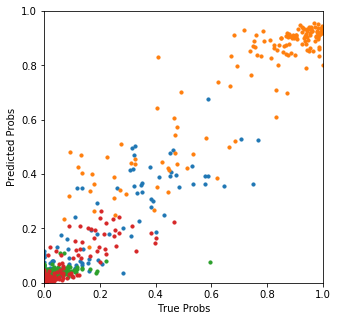

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    ax.scatter(y_batch.detach().numpy()[:,i], torch.exp(probs).detach().numpy()[:,i], s=10)

ax.set_xlabel("True Probs")
ax.set_ylabel("Predicted Probs")
ax.set_xlim([0,1])
ax.set_ylim([0,1]);


# LR for trip generation

In [76]:
# dataloader and model definition

trainset2 = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(trpgen_train, dtype=torch.float))
trainloader2 = DataLoader(trainset2, batch_size=len(trainset2), shuffle=False)

testset2 = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(trpgen_test, dtype=torch.float))
testloader2 = DataLoader(testset2, batch_size=len(testset2), shuffle=False)

mseloss = nn.MSELoss(reduction='mean')

In [77]:
import linear_reg

In [39]:
demo_weights = torch.load(out_dir+"demo_weights.pt")

In [40]:
demo_weights['demo.weight']

tensor([[ 60.1201,   0.6450,   0.7284,   2.8149,  -1.1723,   3.2800,   0.6515,
          15.6323, -13.7578,   3.5966]])

In [48]:
model.demo.weight

Parameter containing:
tensor([[ 61.8849,   0.8933,   1.0213,   3.1698,  -1.3015,   2.9416,   1.2524,
          16.1536, -15.4054,   2.9638]], requires_grad=True)

In [42]:
image_weights = torch.load(out_dir+"image_weights.pt")

In [43]:
image_weights['embed.weight']

tensor([[ 0.0635, -0.0760, -0.0652,  ...,  0.0318,  0.1321, -0.0037]])

In [47]:
model.embed.weight

Parameter containing:
tensor([[-0.0001,  0.0041,  0.0016,  ..., -0.0003,  0.0084,  0.0007]],
       requires_grad=True)

In [60]:
# decay rates for embedding
w1_list = [1.3,1.4]
# decay rates for demo
w2_list = [0.007]
# lr_list = [0.005,0.01, 0.02]
lr1_list = [0.001,0.002,0.003]
lr2_list = [0.5,0.55]

dim_demo = len(demo_variables)
dim_embed = 2048*output_dim*output_dim

for lr1, lr2 in itertools.product(lr1_list, lr2_list):
    
    for w1, w2 in itertools.product(w1_list, w2_list):
    
        # model setup
        model = linear_reg.LR(dim_embed=dim_embed, dim_demo=dim_demo, 
                              demo_weights=demo_weights, image_weights=image_weights)

        embed_params = []
        demo_params = []
        other_params = []
        for name, m in model.named_parameters():
    #             print(name)
            if 'embed' in name:
                embed_params.append(m)
            elif 'demo' in name:
                demo_params.append(m)
            else:
                other_params.append(m)

        optimizer = torch.optim.Adam([{'params':embed_params,'weight_decay':w1,'lr':lr1},
                                      {'params':demo_params,'weight_decay':w2,'lr':lr2},
                                      {'params':other_params,'weight_decay':0}])

        # model training
        ref1 = 0
        ref2 = 0

        for epoch in range(500):

            mse_ = 0

            for batch, (x_batch, y_batch) in enumerate(trainloader2):
                # Compute prediction and loss
                pred = model(x_batch[:, dim_demo:], x_batch[:, :dim_demo])
                pred = F.relu(pred).squeeze()

                mse = mseloss(pred, y_batch)
                mse_ += mse.item()

                # Backpropagation
                optimizer.zero_grad()
                mse.backward()
                optimizer.step()


            train_r = r2_score(y_batch.numpy(), pred.detach().numpy())
            train_rmse = np.sqrt(mse_/len(trainset2))

            if epoch % 10 == 0:
                print(f"[epoch: {epoch:>2d}] Train RMSE : {train_rmse:.3f} R2 score: {train_r:.3f} ")
            loss_ = train_rmse

            if epoch % 5 == 0:
                if epoch > 50:
                    if (np.abs(loss_ - ref1)/ref1<ref1*0.001) & (np.abs(loss_ - ref2)/ref2<ref2*0.001):
                        print("Early stopping at epoch", epoch)
                        break
                    if (ref1 < loss_) & (ref1 < ref2):
                        print("Diverging. stop.")
                        break
                    if loss_ < best:
                        best = loss_
                        best_epoch = epoch
                else:
                    best = loss_
                    best_epoch = epoch

                ref2 = ref1
                ref1 = loss_

            if epoch % 10 == 0:

                mse_ = 0 

                for batch, (x_batch, y_batch) in enumerate(testloader2):
                    pred = model(x_batch[:, dim_demo:], x_batch[:, :dim_demo])
                    pred = F.relu(pred).squeeze()

                    mse = mseloss(pred, y_batch)
                    mse_ += mse.item()

                test_rmse = np.sqrt(mse_/len(testset2))
                test_r = r2_score(y_batch.numpy(),pred.detach().numpy())

                print(f"[epoch: {epoch:>2d}] Test RMSE {test_rmse:.3f} R2 score: {test_r:.3f} ")


#         with open(out_dir+model_code+"_regression_trpgen.csv", "a") as f:
#             f.write("%s,%s,%s,%s,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n" % \
#                 (model_run_date, model_type, zoomlevel, "LR", lr1, lr2, w1,w2, 
#                   train_rmse, train_r, test_rmse, test_r))

[epoch:  0] Train RMSE : 0.358 R2 score: 0.293 
[epoch:  0] Test RMSE 1.009 R2 score: 0.158 
[epoch: 10] Train RMSE : 0.360 R2 score: 0.285 
[epoch: 10] Test RMSE 0.973 R2 score: 0.216 
[epoch: 20] Train RMSE : 0.359 R2 score: 0.289 
[epoch: 20] Test RMSE 0.973 R2 score: 0.216 
[epoch: 30] Train RMSE : 0.359 R2 score: 0.290 
[epoch: 30] Test RMSE 0.971 R2 score: 0.220 
[epoch: 40] Train RMSE : 0.359 R2 score: 0.290 
[epoch: 40] Test RMSE 0.969 R2 score: 0.222 
[epoch: 50] Train RMSE : 0.359 R2 score: 0.290 
[epoch: 50] Test RMSE 0.969 R2 score: 0.223 
Early stopping at epoch 55
[epoch:  0] Train RMSE : 0.359 R2 score: 0.290 
[epoch:  0] Test RMSE 1.010 R2 score: 0.155 
[epoch: 10] Train RMSE : 0.361 R2 score: 0.280 
[epoch: 10] Test RMSE 0.974 R2 score: 0.214 
[epoch: 20] Train RMSE : 0.360 R2 score: 0.286 
[epoch: 20] Test RMSE 0.974 R2 score: 0.214 
[epoch: 30] Train RMSE : 0.359 R2 score: 0.289 
[epoch: 30] Test RMSE 0.971 R2 score: 0.219 
[epoch: 40] Train RMSE : 0.359 R2 score: 0.